# Instruções:
Faça upload dessa [pasta](https://drive.google.com/drive/folders/1Jml-5CQE_QHAXEhhhuZbsdinn-73QjK3?usp=sharing) no google drive. Contém os pesos da YOLO retreinada e as fotos de estilo.

## Montar Google Drive

In [ ]:
from google.colab import drive
root_path = '/content/gdrive/'
drive.mount(root_path)

#alterar o caminho da pasta, no comando abaixo


Mounted at /content/gdrive/


In [ ]:
cd /content/gdrive/MyDrive/Trabalho Final - INF492 (exemplo)

/content/gdrive/MyDrive/Trabalho Final - INF492 (exemplo)


## Instalar dependências


In [ ]:
!pip install tensorflow matplotlib numpy PILLOW tensorflow_hub ultralytics

# Funções para rodar em tempo real (colab)

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_PIL):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  #bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# Transferência de Estilo com rede pré-treinada para 16 estilos diferentes
Ref: https://github.com/ryanwongsa/Real-time-multi-style-transfer <br>
Todos os 16 estilos representados nesse vídeo: https://www.youtube.com/watch?v=p1RYBBEYafA

In [ ]:
!wget https://www.dropbox.com/s/ylfwc7otesv1z6y/pastichemodel-FINAL.pth -P style16/

--2023-07-09 23:50:43--  https://www.dropbox.com/s/ylfwc7otesv1z6y/pastichemodel-FINAL.pth
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ylfwc7otesv1z6y/pastichemodel-FINAL.pth [following]
--2023-07-09 23:50:43--  https://www.dropbox.com/s/raw/ylfwc7otesv1z6y/pastichemodel-FINAL.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfdf5bcd203fd21d286ae1b02ba.dl.dropboxusercontent.com/cd/0/inline/B_huL4n7sY4wp7VIY6tVnBSniX4riBzvN-j2eFZRN87jy66nhdhZmIXvIWCO706LXwuGCI4lYQSofe3yf-PAUlmnI-v0cRHkGmR8-wXMZZFy_4ZHgmaArphsqFJ3S1F3rABHdK2zz8eL-qt3nXQRL6MU_RfBtS8zeoKJSe-0JWMqCA/file# [following]
--2023-07-09 23:50:43--  https://ucfdf5bcd203fd21d286ae1b02ba.dl.dropboxusercontent.com/cd/0/inline/B_huL4n7sY4wp7VIY6tVnBSniX4riBzvN-j2eFZRN87j

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms, utils
from glob import glob
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
import numpy as np
from PIL import Image
from skimage import io, transform

In [ ]:
#@title PasticheModel
#CÓDIGO EXTRAÍDO DE : https://github.com/ryanwongsa/Real-time-multi-style-transfer
class CondConvolution(nn.Module):
    def __init__(self, input_filters, output_filters, kernel_size, padding, stride,num_styles,act=True):
        super(CondConvolution, self).__init__()

        self.reflection2d = nn.ReflectionPad2d(padding)
        self.conv = nn.Conv2d(input_filters, output_filters,kernel_size=kernel_size, stride=stride)
        self.instnorm = nn.InstanceNorm2d(output_filters, affine=True)
        self.act = act
        self.gamma = torch.nn.Parameter(data=torch.Tensor(num_styles, output_filters), requires_grad=True)
        self.gamma.data.uniform_(1.0, 1.0)

        self.beta = torch.nn.Parameter(data=torch.Tensor(num_styles, output_filters), requires_grad=True)
        self.beta.data.uniform_(0.0, 0.0)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight,mean=0, std= 0.01)
            elif isinstance(m, nn.InstanceNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, style_no, style_no2=None, alpha=None):

        x = self.reflection2d(x)
        x = self.conv(x)
        x = self.instnorm(x)
        b,d,w,h =x.size()
        x = x.view(b,d,w*h)

        if alpha != None and style_no2!=None:
            gamma = alpha * self.gamma[style_no] + (1 - alpha) * self.gamma[style_no2]
            beta = alpha * self.beta[style_no] + (1 - alpha) * self.beta[style_no2]
        else:
            gamma = self.gamma[style_no]
            beta = self.beta[style_no]
        x = (x*gamma.unsqueeze(-1).expand_as(x)+beta.unsqueeze(-1).expand_as(x)).view(b,d,w,h)


        if self.act==True:
            x = F.relu(x)
        return x

class ResBlock(nn.Module):
    def __init__(self,num_styles):
        super(ResBlock, self).__init__()
        self.res_conv1 = CondConvolution(128, 128, 3, 1, (1,1), num_styles)
        self.res_conv2 = CondConvolution(128, 128, 3, 1, (1,1), num_styles, False)

    def forward(self, x, style_no, style_no2, alpha):
        residual = x
        out = self.res_conv1(x,style_no, style_no2, alpha)
        out = self.res_conv2(out,style_no, style_no2, alpha)
        out += residual
        return out

class Upsampling(nn.Module):
    def __init__(self, input_filters, output_filters, kernel_size, padding, stride,num_styles):
        super(Upsampling, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = CondConvolution(input_filters, output_filters, kernel_size,padding,stride,num_styles)

    def forward(self, x,style_no, style_no2, alpha):
        x = self.upsample(x)
        x = self.conv(x, style_no, style_no2, alpha)
        return x

class PasticheModel(nn.Module):
    def __init__(self, num_styles):
        super(PasticheModel, self).__init__()
        self.conv_1 = CondConvolution(3, 32, 9, 4, (1,1),num_styles)
        self.conv_2 = CondConvolution(32, 64, 3, 1, (2,2),num_styles)
        self.conv_3 = CondConvolution(64, 128, 3, 1, (2,2),num_styles)

        self.upsample1 = Upsampling(128,64,3,1,(1,1),num_styles)
        self.upsample2 = Upsampling(64,32,3,1,(1,1),num_styles)

        self.res_block1 = ResBlock(num_styles)
        self.res_block2 = ResBlock(num_styles)
        self.res_block3 = ResBlock(num_styles)
        self.res_block4 = ResBlock(num_styles)

        self.conv_4 = CondConvolution(32, 3, 9, 4, (1,1),num_styles, False)


    def forward(self, x, style_no, style_no2=None,alpha=None):
        x = self.conv_1(x, style_no, style_no2,alpha)
        x = self.conv_2(x, style_no, style_no2,alpha)
        x = self.conv_3(x, style_no, style_no2,alpha)


        x=self.res_block1(x, style_no, style_no2,alpha)
        x=self.res_block2(x, style_no, style_no2,alpha)
        x=self.res_block3(x, style_no, style_no2,alpha)
        x=self.res_block4(x, style_no, style_no2,alpha)

        x = self.upsample1(x, style_no, style_no2,alpha)
        x = self.upsample2(x, style_no, style_no2,alpha)

        x = self.conv_4(x, style_no, style_no2,alpha)
        x = F.sigmoid(x)
        return x

In [ ]:
#@title Inferencer
#CÓDIGO EXTRAÍDO DE https://github.com/ryanwongsa/Real-time-multi-style-transfer
class Inferencer(object):
    def __init__(self, pastiche_model,device,image_size):
        self.pastichemodel = pastiche_model
        self.device = device

        self.pastichemodel = self.pastichemodel.to(self.device)
        self.pastichemodel = self.pastichemodel.eval()

        self.mean = [0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]

        self.transformer = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
            transforms.Normalize(mean=self.mean,
                                 std=self.std)
        ])


    def load_model_weights(self, dir_model):
        self.pastichemodel.load_state_dict(torch.load(dir_model))

    def eval_image(self, img, style_num,style_num2=None,alpha=None):
        out = self.transformer(img)
        res = self.pastichemodel(out.unsqueeze(0).to(self.device),style_num,style_num2,alpha)
        res_img = Image.fromarray(np.uint8(np.moveaxis(res[0].cpu().detach().numpy()*255.0, 0, 2)))
        return res_img

# Integrando YOLO + Transferência de Estilo

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import json
from ultralytics import YOLO
import json
import matplotlib.pyplot as plt
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from IPython.display import display, Javascript, Image
import io

model = YOLO('best-ml.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_styles = 16
image_size = 256
model_save_dir = "style16/pastichemodel-FINAL.pth"

pastichemodel = PasticheModel(num_styles)

inference = Inferencer(pastichemodel,device,image_size)
inference.load_model_weights(model_save_dir)

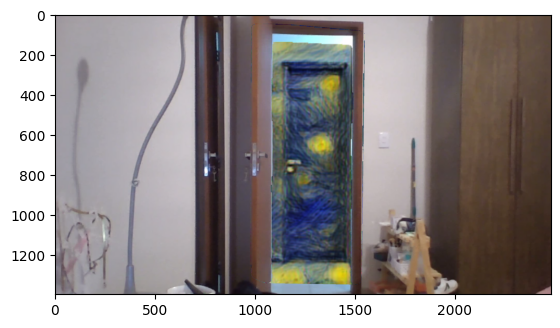

0.8561687469482422 segundos


In [ ]:
from PIL import Image
def estiliza_imagem(img, filter=5):# Converter de BGR para RGB
    img_PIL = Image.fromarray(img)
    img_PIL.thumbnail((image_size,image_size),Image.ANTIALIAS)
    styled_img = inference.eval_image(img_PIL, 1,filter,0.0)

    results = model(img, verbose=False)
    height, width, _ = img.shape
    styled_img = np.array(styled_img)
    styled_img = cv2.cvtColor(styled_img, cv2.COLOR_RGB2BGR)  # Converter de RGB para BGR
    # plt.imshow(styled_img)
    # plt.show()

    res_json = json.loads(results[0].tojson())
    index = 0
    higher_conf = 0
    boxes = []
    label = 0
    for i, result in enumerate(res_json):
        if result['confidence'] > higher_conf:
            index = i
            higher_conf = result['confidence']
            boxes = result['box']
            label = result['class']
    if label != 0:
        mask_door = results[index].masks.data[index].cpu().numpy() * 255
        mask_door = cv2.cvtColor(mask_door.astype(np.uint8), cv2.COLOR_GRAY2BGR)
        mask_door = cv2.resize(mask_door, (width, height))

        x1 = int(boxes['x1'])
        y1 = int(boxes['y1'])
        x2 = int(boxes['x2'])
        y2 = int(boxes['y2'])
        #Colando o bounding box estilizado na foto original
        #Sem usar convexHull
        # aux = img.copy()
        # aux = cv2.cvtColor(aux, cv2.COLOR_RGB2BGR)
        # source_image = cv2.resize(styled_img, (width, height))
        # cropped_image = source_image[y1:y2, x1:x2]
        # aux[y1:y2, x1:x2] = cropped_image
        # image_s = aux
        # image_s = cv2.resize(image_s, (width, height))
        gray = cv2.cvtColor(mask_door, cv2.COLOR_BGR2GRAY)

        _, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        largest_contour = max(contours, key=cv2.contourArea)

        hull = cv2.convexHull(largest_contour)

        convex_hull_image = np.zeros(mask_door.shape[:2], dtype=np.uint8)

        cv2.drawContours(convex_hull_image, [hull], 0, 255, thickness=cv2.FILLED)

        convex_hull_image = cv2.resize(convex_hull_image, (img.shape[1], img.shape[0]))
        styled_img = cv2.resize(styled_img, (img.shape[1], img.shape[0]))
        moldura = cv2.bitwise_and(styled_img, styled_img, mask=convex_hull_image)
        moldura_mask_inv = cv2.bitwise_not(convex_hull_image) # Inverter a máscara
        moldura_mask_inv = cv2.resize(moldura_mask_inv, (img.shape[1], img.shape[0]))# Redimensionar a máscara para ter o mesmo tamanho da foto original
        moldura_mask_inv = moldura_mask_inv.astype(np.uint8)
        foto_original_bg = cv2.bitwise_and(img, img, mask=moldura_mask_inv)# Aplicar a máscara invertida na foto original para obter a área fora da moldura
        foto_estilizada_final = cv2.add(foto_original_bg, moldura)


        #Colando a moldura da porta sem estilo
        image_original = cv2.resize(img, (width, height))
        moldura_porta = cv2.bitwise_and(image_original, mask_door)

        # Redimensionar a moldura da porta para ter as mesmas dimensões da foto estilizada
        moldura_porta_redimensionada = cv2.resize(moldura_porta, (width, height))

        # Criar a máscara inversa
        mascara_inversa = cv2.bitwise_not(mask_door)

        # Aplicar a máscara inversa à foto estilizada
        mascara_inversa = cv2.resize(mascara_inversa, (width, height))
        foto_estilizada_sem_moldura = cv2.bitwise_and(foto_estilizada_final, mascara_inversa)

        # Combinar a moldura redimensionada e a foto estilizada sem moldura
        foto_final = cv2.bitwise_or(moldura_porta_redimensionada, foto_estilizada_sem_moldura)
        return cv2.cvtColor(foto_final, cv2.COLOR_BGR2RGB)
    else:
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
import time
inicio = time.time()
img = cv2.imread('teste.jpg')
img = estiliza_imagem(img)
final = time.time()
plt.imshow(img)
plt.show()
print(final-inicio, 'segundos')

In [ ]:
#@title Processar vídeos já gravados


input_video_path = 'videos/video10.mp4'  # @param {type:"string"}
output_video_path = 'videos_editados/video10_ta.mp4' # @param {type:"string"}
# filter = 5 # @param {type:"string"}

input_video = cv2.VideoCapture(input_video_path)

# Obter as propriedades do vídeo de entrada
fps = input_video.get(cv2.CAP_PROP_FPS)
width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Definir as configurações do vídeo de saída
codec = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(output_video_path, codec, fps, (width, height))

# Processar cada frame do vídeo de entrada
while input_video.isOpened():
    ret, frame = input_video.read()

    if not ret:
        break

    # Estilizar o frame usando a função portal_img
    styled_frame = estiliza_imagem(frame, 5)
    styled_frame = cv2.cvtColor(styled_frame, cv2.COLOR_RGB2BGR)

    # Salvar o frame estilizado no vídeo de saída
    output_video.write(styled_frame)

    # cv2.imshow('Styled Frame', styled_frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

# Liberar os recursos
input_video.release()
output_video.release()
cv2.destroyAllWindows()

In [ ]:
#@title Processar em tempo real
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    img_pronta = estiliza_imagem(np.array(img), 5)
    img_pronta = Image.fromarray(img_pronta)
    if img_pronta != None:
      bbox_bytes = bbox_to_bytes(img_pronta)
      # update bbox so next frame gets new overlay
      bbox = bbox_bytes

<IPython.core.display.Javascript object>

# Transferência Arbitrária de Estilo
Combinar o conteúdo de uma imagem com o estilo de outra, criando uma nova imagem que incorpora características estilísticas da imagem de estilo. Usamos https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2.

In [ ]:
import functools
import os
import PIL
from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import io
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.12.0
TF Hub version:  0.13.0
Eager mode enabled:  True
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# @title Define image loading and visualization functions  { display-mode: "form" }
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image, image_size=(256, 256), preserve_aspect_ratio=True):
  # max dimension of the images that we are importing
  max_dim = 512
  #Here we are loading our file, decoding it into a 3 dimensional tensor and converting it into a file based on format
  img = tf.io.read_file(image)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def preprocess_image(image, max_dim):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converter para formato RGB se necessário
    img = img.astype(np.float32) / 255.0  # Normalizar os valores dos pixels para o intervalo [0, 1]

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = tf.reduce_max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = tf.expand_dims(img, axis=0)  # Adicionar uma dimensão extra para corresponder ao formato [batch_size, height, width, channels]

    return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()


In [ ]:
# @title Load Hub Model { display-mode: "form" }

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

# Integrando YOLO + Transferência Arbitrária de Estilo


In [ ]:
from ultralytics import YOLO
import json
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display



model = YOLO('best-ml.pt')

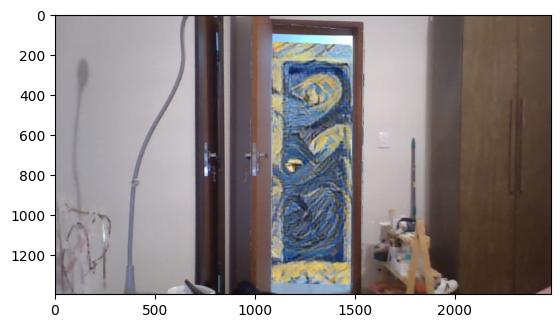

0.3181271553039551 segundos


In [ ]:
def portal_img(img, style_path):
  content_image = preprocess_image(cv2.cvtColor(img, cv2.COLOR_RGB2BGR),512)
  style_image = load_image(style_path)
  stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
  styled_img = tensor_to_image(stylized_image)

  results = model(img, verbose=False)
  height, width, _ = img.shape
  styled_img = np.array(styled_img)
  styled_img = cv2.cvtColor(styled_img, cv2.COLOR_RGB2BGR)  # Converter de RGB para BGR

  res_json = json.loads(results[0].tojson())
  index = 0
  higher_conf = 0
  boxes = []
  label = 0
  for i, result in enumerate(res_json):
      if result['confidence'] > higher_conf:
          index = i
          higher_conf = result['confidence']
          boxes = result['box']
          label = result['class']
  if label != 0:
      mask_door = results[index].masks.data[index].cpu().numpy() * 255
      mask_door = cv2.cvtColor(mask_door.astype(np.uint8), cv2.COLOR_GRAY2BGR)
      mask_door = cv2.resize(mask_door, (width, height))

      x1 = int(boxes['x1'])
      y1 = int(boxes['y1'])
      x2 = int(boxes['x2'])
      y2 = int(boxes['y2'])
      #Colando o bounding box estilizado na foto original
      #Sem usar convexHull
      # aux = img.copy()
      # aux = cv2.cvtColor(aux, cv2.COLOR_RGB2BGR)
      # source_image = cv2.resize(styled_img, (width, height))
      # cropped_image = source_image[y1:y2, x1:x2]
      # aux[y1:y2, x1:x2] = cropped_image
      # image_s = aux
      # image_s = cv2.resize(image_s, (width, height))
      # plt.imshow(mask_door)
      # plt.show()
      gray = cv2.cvtColor(mask_door, cv2.COLOR_BGR2GRAY)

      _, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

      contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      largest_contour = max(contours, key=cv2.contourArea)

      hull = cv2.convexHull(largest_contour)

      convex_hull_image = np.zeros(mask_door.shape[:2], dtype=np.uint8)

      cv2.drawContours(convex_hull_image, [hull], 0, 255, thickness=cv2.FILLED)

      convex_hull_image = cv2.resize(convex_hull_image, (img.shape[1], img.shape[0]))
      styled_img = cv2.resize(styled_img, (img.shape[1], img.shape[0]))

      moldura = cv2.bitwise_and(styled_img, styled_img, mask=convex_hull_image)
      moldura_mask_inv = cv2.bitwise_not(convex_hull_image) # Inverter a máscara
      moldura_mask_inv = cv2.resize(moldura_mask_inv, (img.shape[1], img.shape[0]))# Redimensionar a máscara para ter o mesmo tamanho da foto original
      moldura_mask_inv = moldura_mask_inv.astype(np.uint8)
      foto_original_bg = cv2.bitwise_and(img, img, mask=moldura_mask_inv)# Aplicar a máscara invertida na foto original para obter a área fora da moldura
      foto_estilizada_final = cv2.add(foto_original_bg, moldura)
      foto_estilizada_final = cv2.cvtColor(foto_estilizada_final, cv2.COLOR_BGR2RGB)


      #Colando a moldura da porta sem estilo
      image_original = cv2.resize(img, (width, height))
      moldura_porta = cv2.bitwise_and(image_original, mask_door)
      moldura_porta = cv2.cvtColor(moldura_porta, cv2.COLOR_RGB2BGR)

      # Redimensionar a moldura da porta para ter as mesmas dimensões da foto estilizada
      moldura_porta_redimensionada = cv2.resize(moldura_porta, (width, height))

      # Criar a máscara inversa
      mascara_inversa = cv2.bitwise_not(mask_door)

      # Aplicar a máscara inversa à foto estilizada
      mascara_inversa = cv2.resize(mascara_inversa, (width, height))
      foto_estilizada_sem_moldura = cv2.bitwise_and(foto_estilizada_final, mascara_inversa)

      # Combinar a moldura redimensionada e a foto estilizada sem moldura
      foto_final = cv2.bitwise_or(moldura_porta_redimensionada, foto_estilizada_sem_moldura)
      return foto_final
  else:
      return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
import time
img = cv2.imread('teste.jpg')
inicio = time.time()
img = portal_img(img, 'vangogh.jpg')
final = time.time()

plt.imshow(img)
plt.show()
print(final - inicio, 'segundos')


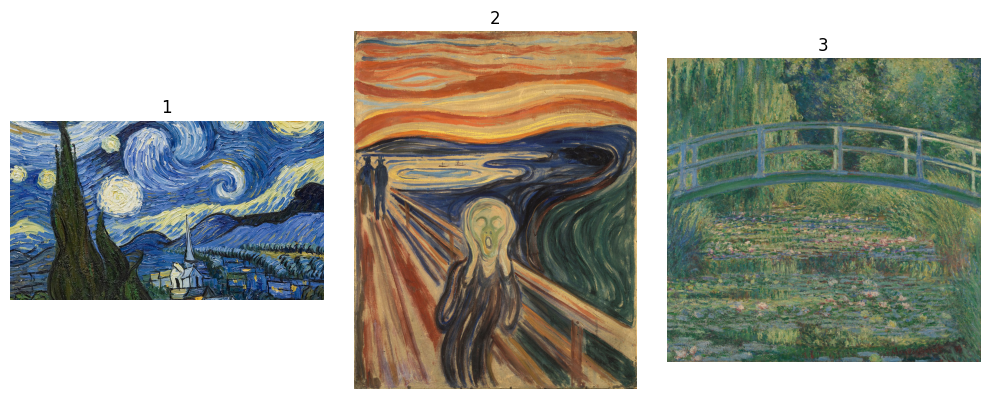

In [ ]:
#@title Opções de fotos para estilização
import matplotlib.pyplot as plt
from PIL import Image

# Carregando as imagens
imagem1 = Image.open("vangogh.jpg")
imagem2 = Image.open("munch.jpg")
imagem3 = Image.open("monet.jpg")

# Criando a figura e os subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Exibindo as imagens nos subplots
axs[0].imshow(imagem1)
axs[0].axis('off')
axs[0].set_title('1')

axs[1].imshow(imagem2)
axs[1].axis('off')
axs[1].set_title('2')

axs[2].imshow(imagem3)
axs[2].axis('off')
axs[2].set_title('3')

# Ajustando o layout
plt.tight_layout()

# Exibindo a figura
plt.show()


In [ ]:
#@title Processar vídeos já gravados
input_video_path = 'videos/video10.mp4'  # @param {type:"string"}
output_video_path = 'videos_editados/video1231.mp4' # @param {type:"string"}
estilo = 2 #@param {type: int} n
if estilo == 1:
  style_path = 'vangogh.jpg'
elif estilo == 2:
  style_path = 'munch.jpg'
else:
  style_path = 'monet.jpg'


# Abrir o vídeo de entrada
input_video = cv2.VideoCapture(input_video_path)

# Obter as propriedades do vídeo de entrada
fps = input_video.get(cv2.CAP_PROP_FPS)
width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Definir as configurações do vídeo de saída
codec = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(output_video_path, codec, fps, (width, height))

# Processar cada frame do vídeo de entrada
while input_video.isOpened():
    ret, frame = input_video.read()

    if not ret:
        break

    # Estilizar o frame usando a função portal_img
    styled_frame = portal_img(frame, style_path)
    styled_frame = cv2.cvtColor(styled_frame, cv2.COLOR_BGR2RGB)
    # plt.imshow(styled_frame)
    # plt.show()

    # Salvar o frame estilizado no vídeo de saída
    output_video.write(styled_frame)

    # cv2.imshow('Styled Frame', styled_frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

# Liberar os recursos
input_video.release()
output_video.release()
cv2.destroyAllWindows()

In [ ]:
#@title Processando em tempo real
# start streaming video from webcam
video_stream()
estilo = 2 #@param {type: int} n
if estilo == 1:
  style_path = 'vangogh.jpg'
if estilo == 1:
  style_path = 'munch.jpg'
else:
  style_path = 'monet.jpg'
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    img_pronta = portal_img(np.array(img), style_path)
    img_pronta = Image.fromarray(img_pronta)
    if img_pronta != None:
      bbox_bytes = bbox_to_bytes(img_pronta)
      # update bbox so next frame gets new overlay
      bbox = bbox_bytes

<IPython.core.display.Javascript object>